In [11]:
import preprocessing as pp
import detection
import measurement

import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math


### GLOBAL FLAGS ###
DO_MEAS = False

# 0. Helper functions

In [12]:
def draw_lines_circles(img, lines, circles, thickness=2):

    base_n_shapes = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2RGB)

    # Draw lines
    if lines:   # if lines is not empty
        for (x1, y1, x2, y2) in lines:
            cv2.line(base_n_shapes, (x1, y1), (x2, y2), (0, 255, 0), thickness)
        for (x1, y1, x2, y2) in lines:
            cv2.circle(base_n_shapes, (x1, y1), 2, (0, 0, 255), thickness)
            cv2.circle(base_n_shapes, (x2, y2), 2, (0, 0, 255), thickness)

    # Draw circles
    print(circles)
    if circles:     # if circles is not empty
        for (x, y, r) in circles:
            cv2.circle(base_n_shapes, (x, y), r, (0, 255, 0), thickness)
            cv2.circle(base_n_shapes, (x, y), 2, (0, 0, 255), thickness)

    return base_n_shapes



# 1. Define version of functions to use: get_edges(), find_lines(), find_circles()

In [13]:
f_get_edges = pp.get_edges
# f_get_edges = pp.get_edges_2

f_find_lines = detection.find_lines_HT

# f_find_circles = detection.find_circles_HT
f_find_circles = detection.find_circles

# 2. Specify, load, & display test images to use

In [14]:
base_path = os.getcwd()
print("Base path:", base_path)
files = []

# parts_path = os.path.join(base_path, "data", "physical parts")
# files.append( os.path.join(parts_path, "Basic II base part.jpg") )
# files.append( os.path.join(parts_path, "mill part 2.jpeg") )
# files.append( os.path.join(parts_path, "servo mount 1.jpeg") )
# files.append( os.path.join(parts_path, "small PCB 2.jpeg") )

# parts_path = os.path.join(base_path, "data", "physical parts", "52mm 7in")
# img11 = os.path.join(parts_path, "Basic II base part 2.jpeg")
# img22 = os.path.join(parts_path, "mill part 2.jpeg")
# img33 = os.path.join(parts_path, "servo mount 1.jpeg")
# img44 = os.path.join(parts_path, "small PCB 2.jpeg")


parts_path = os.path.join(base_path, "data", "physical parts", "52mm 7in blk")
# files.append( os.path.join(parts_path, "Basic II base part 1 thk0.50.jpeg") )
files.append( os.path.join(parts_path, "Basic II base part 2 thk0.50.jpeg") )
files.append( os.path.join(parts_path, "mill part 1 thk0.50.jpeg") )
files.append( os.path.join(parts_path, "servo mount 1 thk0.20.jpeg") )
files.append( os.path.join(parts_path, "small PCB 2 thk0.06.jpeg") )

titles = [str(i) for i in range(1, len(files)+1)]

imgs = detection.show_images_from_files(files, titles)

Base path: c:\Users\jtyzhang\Desktop\jtyzhang\EECS442\EECS442_Final_Project


# 3. Pass each image through f_get_edges(); extract result & intermediate images

In [15]:
img_results = []
for img in imgs:
    # find edges on original image
    edges, interms = f_get_edges(img, return_interm=True)

    # find features & overlay them on edge map
    # we can perform measurement on the following outputs 
    lines = f_find_lines(edges)
    # circles = f_find_circles(edges)
    circles = f_find_circles(img, return_type="circles")
    img_lines = draw_lines_circles(edges, lines, [])
    img_circles = draw_lines_circles(edges, [], circles)
    # features = draw_lines_circles(edges, lines, circles)


    # doing measurement here
    if DO_MEAS:
        measured_lines = measurement.measure_line(lines, conversion_ratio=1.0)
        measured_circles = measurement.measure_circle(circles, conversion_ratio=1.0)


    # organize results
    result = [img]
    result.extend(interms)
    result.append(edges)
    result.append(img_lines)
    result.append(img_circles)
    # result.append(features)
    
    # store results of this instance
    img_results.append(result)

    # display measurement results
    if DO_MEAS:
        out = measurement.draw_measurements(img, measured_lines, measured_circles)
        plt.figure()
        plt.imshow(out)

[]
[[[ 83  78  58]
  [ 87  82  62]
  [ 97  92  72]
  ...
  [ 58  58  50]
  [ 58  58  50]
  [ 56  56  48]]

 [[ 82  77  57]
  [ 84  79  59]
  [ 92  87  67]
  ...
  [ 60  60  52]
  [ 57  57  49]
  [ 53  53  45]]

 [[ 81  76  56]
  [ 81  76  56]
  [ 85  80  60]
  ...
  [ 59  59  51]
  [ 53  53  45]
  [ 50  50  42]]

 ...

 [[157 157 155]
  [159 159 157]
  [169 169 167]
  ...
  [ 46  42  31]
  [ 51  47  36]
  [ 53  49  38]]

 [[177 177 175]
  [173 173 171]
  [169 169 167]
  ...
  [ 41  37  26]
  [ 44  40  29]
  [ 45  41  30]]

 [[187 187 185]
  [181 181 179]
  [170 170 168]
  ...
  [ 40  36  25]
  [ 42  38  27]
  [ 41  37  26]]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

# 4. Plot all images in organized format
images (or different objects) listed along rows;
intermediate results of each object listed along columns

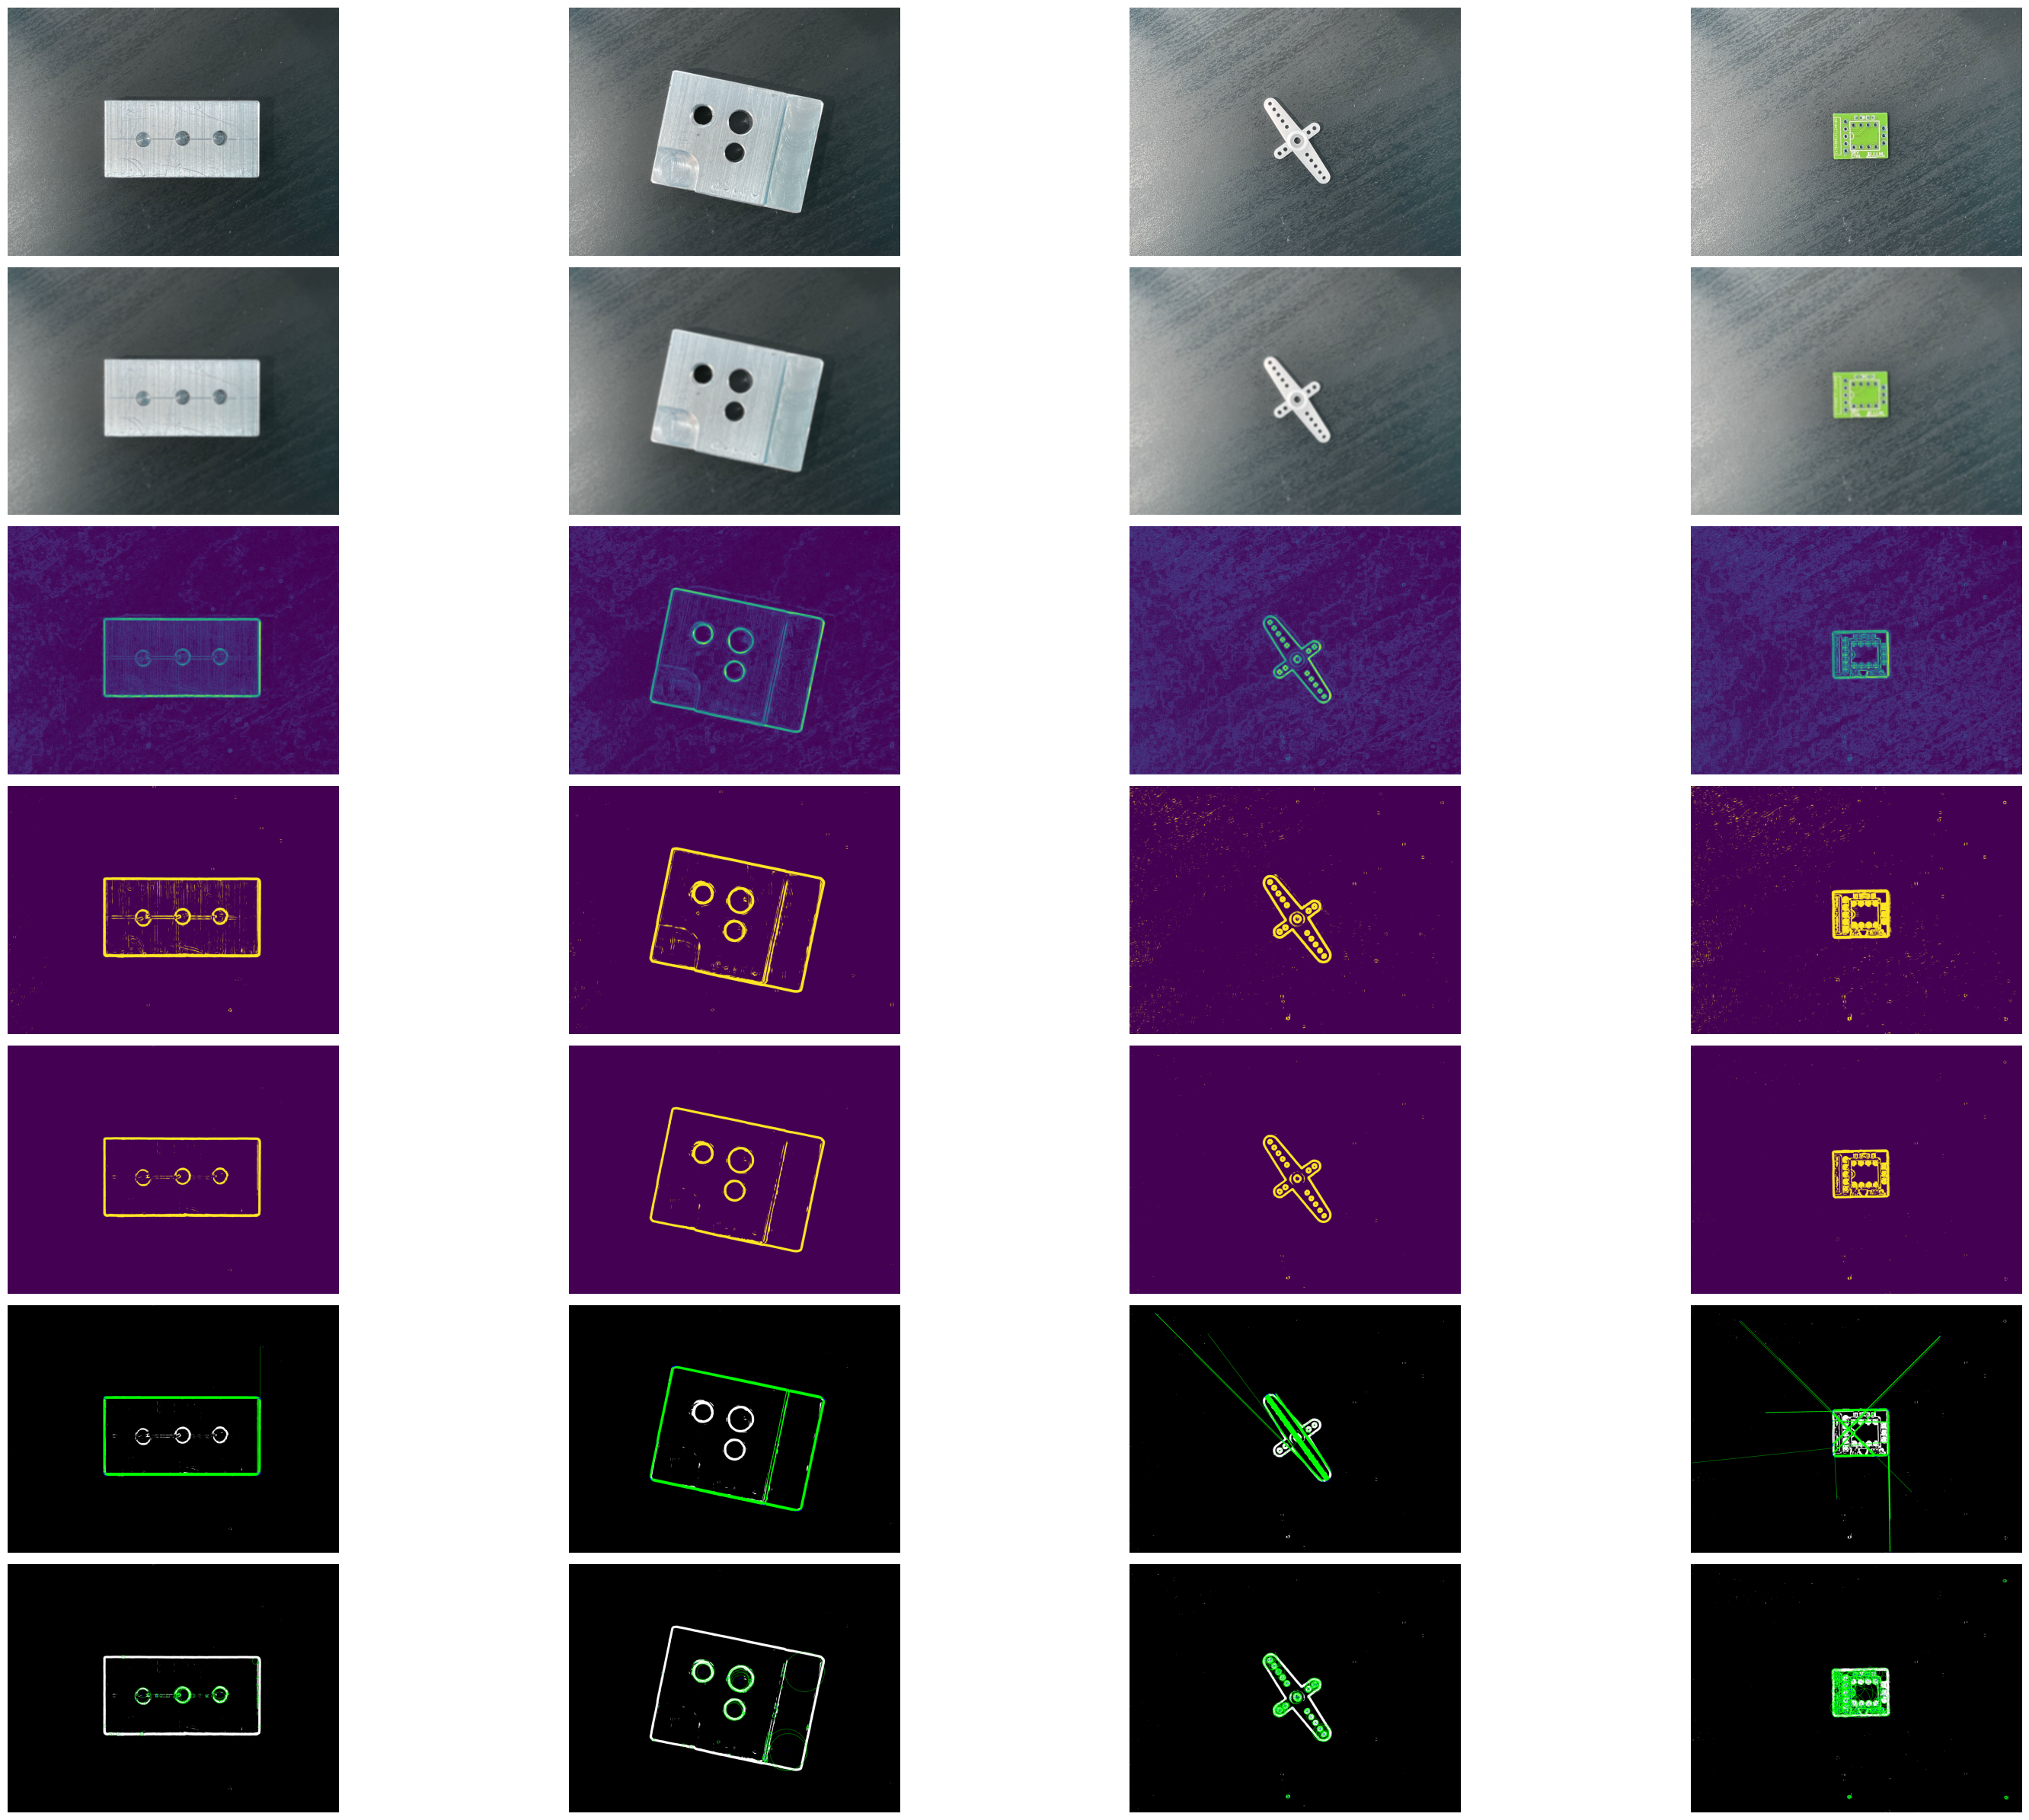

In [ ]:
figsize = (32,24)    # physical part images taken from iphone should be of shape 4:3
cols = len(img_results)     # plot objects along cols
rows = len(img_results[0])  # plot steps along rows

plt.figure(figsize=figsize)
i = 1
for r in range(rows):
    for obj in img_results:
        plt.subplot(rows, cols, i)
        rst = obj[r]
        plt.imshow(rst)
        plt.axis('off')
        i += 1
plt.tight_layout()
plt.show()


# Filtration: 12/2/2025

Define filtration methods

In [ ]:
from sklearn.cluster import DBSCAN

def filter_lines(lines, eps_pos=10.0, eps_len=20.0, eps_angle=0.1, min_samples=2):
    if not lines:
        return []

    cpfs = []
    for (x1, y1, x2, y2) in lines:
        x0 = (x1 + x2) / 2.0
        y0 = (y1 + y2) / 2.0
        L  = math.hypot(x2 - x1, y2 - y1)
        t  = math.atan2(y2 - y1, x2 - x1)
        if t < 0:
            t += math.pi
        cpfs.append((x0, y0, L, t))

    cpfs = np.array(cpfs, dtype=float)

    # Scale features for DBSCAN
    X = np.empty_like(cpfs)
    X[:, 0] = cpfs[:, 0] / eps_pos
    X[:, 1] = cpfs[:, 1] / eps_pos
    X[:, 2] = cpfs[:, 2] / eps_len
    X[:, 3] = cpfs[:, 3] / eps_angle

    db = DBSCAN(eps=3.0, min_samples=min_samples)
    labels = db.fit_predict(X)

    filtered = []
    unique_labels = set(labels)
    for lbl in unique_labels:
        if lbl == -1:
            continue

        cluster_cpfs = cpfs[labels == lbl]
        if cluster_cpfs.size == 0:
            continue

        x0 = np.median(cluster_cpfs[:, 0])
        y0 = np.median(cluster_cpfs[:, 1])
        L  = np.max(cluster_cpfs[:, 2])
        t  = np.median(cluster_cpfs[:, 3])

        # Convert back to (x1, y1, x2, y2)
        dx = (L / 2.0) * math.cos(t)
        dy = (L / 2.0) * math.sin(t)

        x1 = int(round(x0 - dx))
        y1 = int(round(y0 - dy))
        x2 = int(round(x0 + dx))
        y2 = int(round(y0 + dy))

        filtered.append((x1, y1, x2, y2))

    return filtered


In [ ]:
def filter_circles(circles):
    if not circles:
        return [], np.zeros((height, width), dtype=np.uint8)

    max_x = max(x + r for x, y, r in circles)
    max_y = max(y + r for x, y, r in circles)
    width  = max(1, max_x + 5)
    height = max(1, max_y + 5)

    canvas = np.zeros((height, width), dtype=np.uint8)

    for x, y, r in circles:
        if r <= 0:
            continue
        cv2.circle(canvas, (x, y), r, 255, thickness=-1)

    detected = cv2.HoughCircles(
        canvas,
        method=cv2.HOUGH_GRADIENT,
        dp=1.0,
        minDist=2,
        param1=70,
        param2=30, # Making this actually not as difficult to detect circles for mashed circles
        minRadius=1, #Make this higher once cropping is done well
        maxRadius=0
    )

    if detected is None:
        return [], canvas

    detected = np.round(detected[0, :]).astype(int)
    return [(int(c[0]), int(c[1]), int(c[2])) for c in detected], canvas


Redo pipeline outlined above + filtration

In [ ]:
img_results_filtered = []
i = 0

CROP = True
for img in imgs:
    if(CROP):
        img = pp.crop_largest_structure(img)[0]

    i += 1
    # find edges on original image
    edges, interms = f_get_edges(img, return_interm=True)

    # find features & overlay them on edge map
    # we can perform measurement on the following outputs 
    lines = f_find_lines(edges)
    circles = f_find_circles(edges)

    # FILTRATION 
    lines = filter_lines(lines)
    circles, fake_canvas = filter_circles(circles)
    print(f"Image {i} number of filtered lines: {len(lines)}")
    print(f"Image {i} number of filtered circles: {len(circles)}")


    img_lines = draw_lines_circles(edges, lines, [], 5)
    img_circles = draw_lines_circles(edges, [], circles, 5)
    # features = draw_lines_circles(edges, lines, circles)


    if DO_MEAS:
        measured_lines = measurement.measure_line(lines, conversion_ratio=1.0)
        measured_circles = measurement.measure_circle(circles, conversion_ratio=1.0)


    result = [img]
    result.extend(interms)
    result.append(edges)
    result.append(fake_canvas)
    result.append(img_lines)
    result.append(img_circles)
    # result.append(features)
    
    # store results of this instance
    img_results_filtered.append(result)

    # display measurement results
    if DO_MEAS:
        out = measurement.draw_measurements(img, measured_lines, measured_circles)
        plt.figure()
        plt.imshow(out)

Image 1 number of filtered lines: 5
Image 1 number of filtered circles: 14
Image 2 number of filtered lines: 6
Image 2 number of filtered circles: 0
Image 3 number of filtered lines: 11
Image 3 number of filtered circles: 0
Image 4 number of filtered lines: 15
Image 4 number of filtered circles: 0


In [ ]:
figsize = (32,24)    # physical part images taken from iphone should be of shape 4:3
cols = len(img_results_filtered)     # plot objects along cols
rows = len(img_results_filtered[0])  # plot steps along rows

plt.figure(figsize=figsize)
i = 1
for r in range(rows):
    for obj in img_results_filtered:
        plt.subplot(rows, cols, i)
        rst = obj[r]
        plt.imshow(rst)
        plt.axis('off')
        i += 1
plt.tight_layout()
plt.show()


# Idea 2: Change circle detector to median the midpoints of clusters

Sub point: Get more accurate crop detector (or manually crop for now) to ensure noisy circles can be filtered out by minimum radius checks